In [32]:
import numpy as np
from tensorflow.keras import utils
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

In [33]:
text = "King is a brave man. Queen is a beautiful woman."
# 단어가 수치값을 갖도록 하고, 비슷한 애들은 거리가 가깝게 되도록 벡터로 나타낼 수 있을까?
# stop word도 제거
word_seq = []
for word in text.split():
    if ((word not in ['a', 'is'])):
        word_seq.append(word.lower().strip('.'))
        
print(word_seq)

['king', 'brave', 'man', 'queen', 'beautiful', 'woman']


In [34]:
word_to_idx = {w: i for i, w in enumerate(set(word_seq))}
idx_to_word = {i: w for i, w in enumerate(set(word_seq))}
print(word_to_idx)
print(idx_to_word)

{'woman': 0, 'brave': 1, 'man': 2, 'king': 3, 'queen': 4, 'beautiful': 5}
{0: 'woman', 1: 'brave', 2: 'man', 3: 'king', 4: 'queen', 5: 'beautiful'}


In [35]:
# man을 가지고 brave 예측. 
# autoencoder는 입력을 똑같이 아웃풋으로 만들었는데
# 이걸 그대로 가지고, brave -> king. brave -> man. king -> brave 를 나오게 해서.
# 이 단어의 상관성을 고려한 특징벡터를 뽑아낼 수 있다는 것이 임베딩의 개념. 만들어보자.

# CBOW 임베딩 구현
# 가운데 단어로 양옆 예측
data = []
for i in range(1, len(word_seq) - 1):
    target = word_seq[i]
    neighbor = []
    neighbor.append(word_seq[i-1])
    neighbor.append(word_seq[i+1])
    for w in neighbor:
        data.append([w, target])
data.append([word_seq[1], word_seq[0]])
data.append([word_seq[-2], word_seq[-1]])
# 아래 데이터를 [x, y] 빼서 x--> y 예측하는 예측 모델 만들기
print(data)

[['king', 'brave'], ['man', 'brave'], ['brave', 'man'], ['queen', 'man'], ['man', 'queen'], ['beautiful', 'queen'], ['queen', 'beautiful'], ['woman', 'beautiful'], ['brave', 'king'], ['beautiful', 'woman']]


In [36]:

x_train = []
y_train = []

for w in data:
    x_train.append(list(utils.to_categorical(word_to_idx[w[0]], 6)))
    y_train.append(list(utils.to_categorical(word_to_idx[w[1]], 6)))
x_train = np.array(x_train)
y_train = np.array(y_train)
print(x_train)
print(y_train)

[[0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]]
[[0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0.]]


In [41]:
model = Sequential()
model.add(Dense(2, input_shape=(6,), activation='relu'))
model.add(Dense(6, activation='softmax'))
# 1개의 one hot을 class로 보겠다. 6개의 multi class를 clasification 하는 모델을 만든거다.
# 입력값의 클래스에 대한 소속정도를 합이 1인 것으로 만드는 것이 softmax
# logistic regression 은 2개 class를 나눠주는 거. Sigmoid써서, 0.5보다 크냐 작냐로 0, 1만듦. 아웃풋은 0,1
# multi-class는 softmax. logistic regression을 3개를 쓴다. A or not, B or not, C or not. output은 확률값

# binary_crossentropy는 값이 0 or 1 이니까 
# categorical_crossentropy 는 값이 
model.compile(loss= "categorical_crossentropy", optimizer='adam')
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 2)                 14        
_________________________________________________________________
dense_5 (Dense)              (None, 6)                 18        
Total params: 32
Trainable params: 32
Non-trainable params: 0
_________________________________________________________________


In [42]:
model.fit(x_train, y_train, epochs=10000, verbose=0)

In [43]:
weights = model.get_weights()
print(weights)

# (1,6) (6, 2) (2, 6) ==> (1, 6)
# 6자리 one-hot 을 2개의 특징으로 압축하여 나타내는 (6,2)가 우리가 찾는 특징 vector임

[array([[-1.6294754,  4.872391 ],
       [-1.6296924, -1.7000802],
       [ 3.150425 ,  1.1173719],
       [ 3.0427523,  3.7191327],
       [-1.629896 ,  1.1771926],
       [ 3.1129844, -1.7001678]], dtype=float32), array([1.6294509, 1.7001055], dtype=float32), array([[ 2.1994576,  0.8373426, -2.7429414, -1.909079 ,  2.173208 ,
        -3.4710996],
       [-4.095012 ,  1.6653193,  1.0713344, -2.9106884, -1.3000001,
         3.3605971]], dtype=float32), array([-3.0149496, -4.8581605,  3.985063 ,  3.9837697, -2.8896687,
       -2.6015363], dtype=float32)]


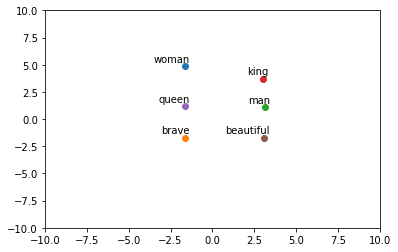

In [45]:
import matplotlib.pyplot as plt

# 6개 단어에 대한 특징벡터를 2차원으로 찍어보자


fig, ax = plt.subplots()
for i, label in enumerate(word_to_idx):
    x, y = weights[0][i]
    plt.xlim(-10, 10)
    plt.ylim(-10, 10)
    plt.scatter(x, y)
    plt.annotate(label, xy=(x, y), xytext=(5,2), textcoords='offset points', ha='right', va='bottom')

In [46]:
# N-gram
data = []
for i in range(1, len(word_seq) - 1):
    target = word_seq[i]
    neighbor = []
    neighbor.append(word_seq[i-1])
    neighbor.append(word_seq[i+1])
    data.append([neighbor, target])
    
# 아래 데이터를 [x, y] 빼서 x--> y 예측하는 예측 모델 만들기
print(data)

[[['king', 'man'], 'brave'], [['brave', 'queen'], 'man'], [['man', 'beautiful'], 'queen'], [['queen', 'woman'], 'beautiful']]


In [51]:
x_train = []
y_train = []

for w in data:
    temp1 = list(utils.to_categorical(word_to_idx[w[0][0]], 6))
    temp2 = list(utils.to_categorical(word_to_idx[w[0][1]], 6))
    x_train.append([temp1, temp2])
    y_train.append(list(utils.to_categorical(word_to_idx[w[1]], 6)))
x_train = np.array(x_train)
y_train = np.array(y_train)
print(x_train)
print(y_train)

[[[0. 0. 0. 1. 0. 0.]
  [0. 0. 1. 0. 0. 0.]]

 [[0. 1. 0. 0. 0. 0.]
  [0. 0. 0. 0. 1. 0.]]

 [[0. 0. 1. 0. 0. 0.]
  [0. 0. 0. 0. 0. 1.]]

 [[0. 0. 0. 0. 1. 0.]
  [1. 0. 0. 0. 0. 0.]]]
[[0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1.]]


In [76]:
from tensorflow.keras.layers import Flatten
# Dense는 입력을 1차원으로만 받을 수 있기 때문에 flatten을 해줘야 함

model = Sequential()
model.add(Flatten(input_shape=(2,6))) # 모양만 바꿔주고 w는 없는 레이어. summary에서 Param #이 0으로 나옴
model.add(Dense(2, activation='relu'))
model.add(Dense(6, activation='softmax'))
model.compile(loss= "categorical_crossentropy", optimizer='adam')
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 12)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 2)                 26        
_________________________________________________________________
dense_17 (Dense)             (None, 6)                 18        
Total params: 44
Trainable params: 44
Non-trainable params: 0
_________________________________________________________________


In [77]:
model.fit(x_train, y_train, epochs=10000, verbose=0)

In [78]:
weights = model.get_weights()
print(weights)

[array([[ 0.08256936,  0.05505437],
       [ 0.5705544 , -0.42237678],
       [-0.79522043, -0.4091264 ],
       [-0.4939003 , -0.05047661],
       [ 5.4930797 , -0.263184  ],
       [-0.02757543, -0.05112016],
       [ 6.033843  , -0.62919444],
       [-0.59087515,  0.5098146 ],
       [-1.0715302 , -0.02185923],
       [-0.541111  ,  0.35596406],
       [ 0.7635196 , -0.42232436],
       [-1.7269424 , -0.30499154]], dtype=float32), array([2.5113137, 0.       ], dtype=float32), array([[-3.7669604 ,  0.06831989,  2.706512  , -2.98448   , -7.814167  ,
         3.4676843 ],
       [-0.41805223, -0.09999144,  0.2592445 , -0.4062616 ,  0.8196512 ,
        -0.53277886]], dtype=float32), array([-2.013325 ,  4.380329 , -1.2993859, -2.0928025,  7.557187 ,
       -7.448603 ], dtype=float32)]


In [79]:
weights = np.sum(weights[0], axis=1)
print(weights)
weights = weights.reshape((6, 2))
print(weights)

[ 0.13762373  0.1481776  -1.2043469  -0.5443769   5.2298956  -0.0786956
  5.404649   -0.08106053 -1.0933895  -0.18514693  0.34119523 -2.031934  ]
[[ 0.13762373  0.1481776 ]
 [-1.2043469  -0.5443769 ]
 [ 5.2298956  -0.0786956 ]
 [ 5.404649   -0.08106053]
 [-1.0933895  -0.18514693]
 [ 0.34119523 -2.031934  ]]


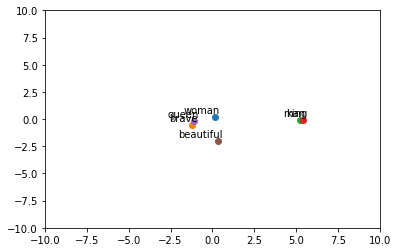

In [80]:
import matplotlib.pyplot as plt

# 6개 단어에 대한 특징벡터를 2차원으로 찍어보자


fig, ax = plt.subplots()
for i, label in enumerate(word_to_idx):
    x, y = weights[i]
    plt.xlim(-10, 10)
    plt.ylim(-10, 10)
    plt.scatter(x, y)
    plt.annotate(label, xy=(x, y), xytext=(5,2), textcoords='offset points', ha='right', va='bottom')